#     Demo of Getting and Deduplicating News Articles from Datanews API

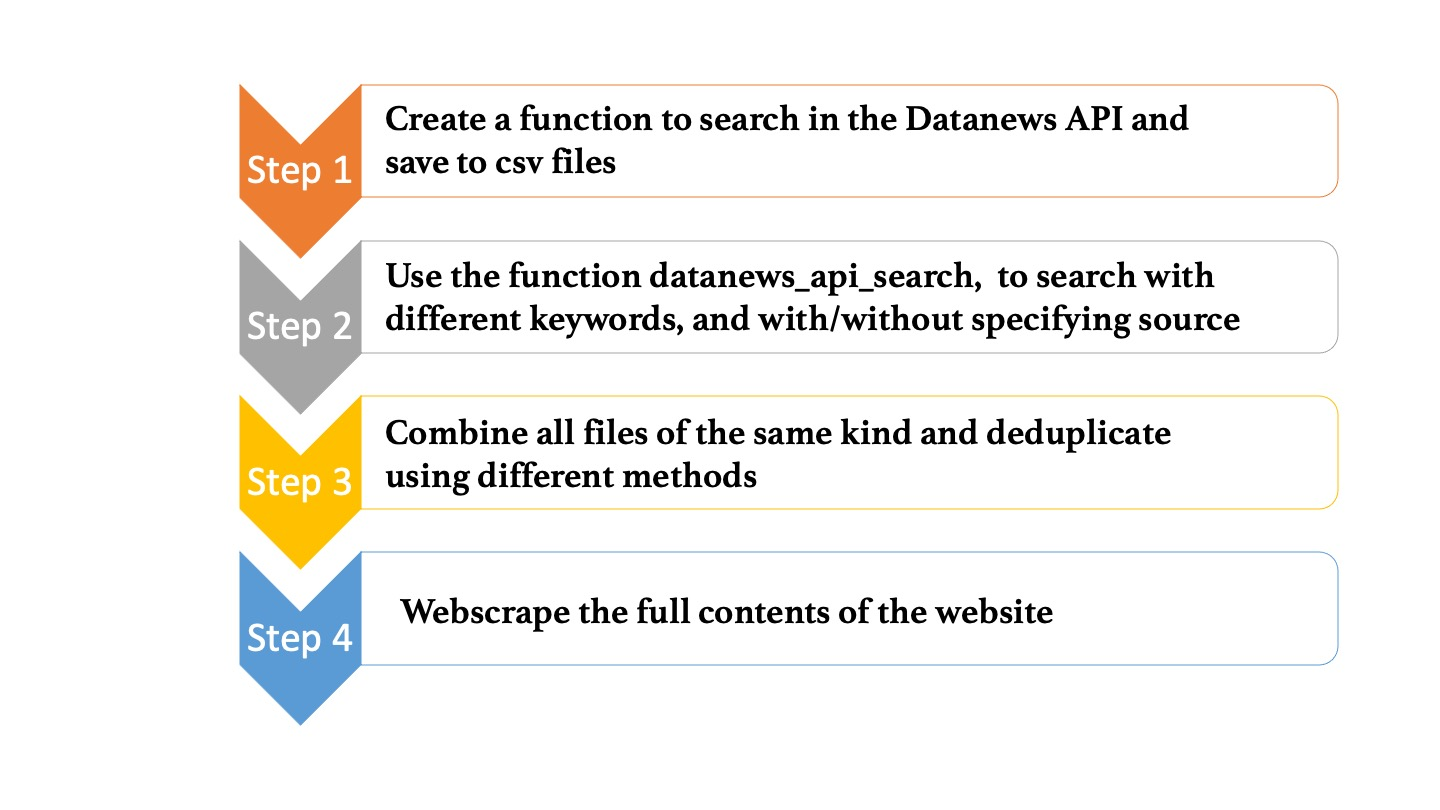

#### Check and change the location of your folder:

In [75]:
import os
os.getcwd()
# change the directory to your folder
os.chdir("/Users/txiao/Box Sync/IDS_Shared/CERE Fertile Ground Project/Sep_30th_CERE_Demo")

#### Import packages for getting entries from Datanews.io

In [80]:
import datanews
import pandas as pd
import math
# for Step 3 combining files:
import glob
# for Step 4 webscraping:
import requests
from bs4 import BeautifulSoup

#### My API key. You can register a free API key and replace it with yours. 

In [79]:
datanews.api_key = '0e1oixqnn4f0fhdl3zod701ok'

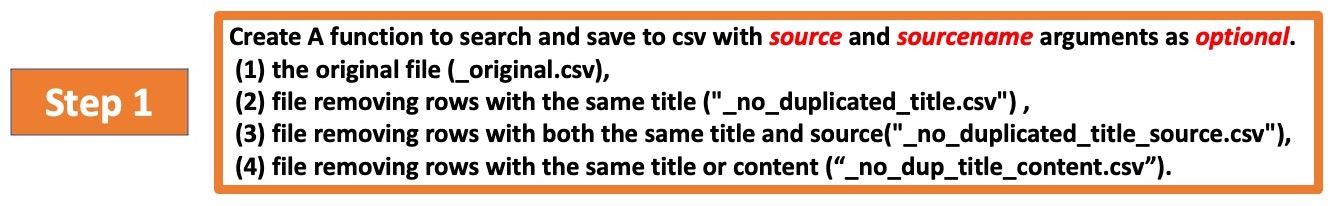

    What can you change?
          (1) As some news from US don't have a country parameter in it, you can try removing " country='US',"  . 
          (2) You can change from_date and to_date
          (3) If you want to deduplicate using other columns, you can replace title in subset = 'title' in drop_duplicates to other columns

In [35]:
def datanews_api_search(keyword,sources=[],sourcename=" "):
    response = datanews.news (q=keyword,country='US',from_date="2018-01-01", to_date="2021-11-01",language=['en'],size=100,page=0,source=sources)
    articles = response['hits']
    df_datanews = pd.DataFrame(articles)
    num_of_pages = int(math.ceil(response['numResults']/100))
    if num_of_pages>1:
        for i in range(1,num_of_pages):
            extra_page_response = datanews.news (q=keyword,country='US',from_date="2018-01-01", to_date="2021-11-01",language=['en'],size=100,page=i)
            extra_articles = extra_page_response['hits']
            df_datanews = df_datanews.append(extra_articles, ignore_index=True)                  
    else: pass
# store file in csv
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~+'''
# Removing punctuations in string
# Using loop + punctuation string
    for ele in keyword: 
        if ele in punc: 
            keyword = keyword.replace(ele, "") 
# remove duplicated rows by title:
    no_dup = df_datanews.drop_duplicates(subset=('title'),ignore_index=True)
# remove duplicated rows by title & source match: 
    no_dup_2 = df_datanews.drop_duplicates(subset=('title','source'),ignore_index=True)
    # remove duplicated rows by title or source match: 
    no_dup_3 = no_dup.drop_duplicates(subset=('content'),ignore_index=True)
    df_datanews.to_csv(sourcename+keyword+"_original.csv")
    no_dup.to_csv(sourcename+keyword+"_no_duplicated_title.csv")
    no_dup_2.to_csv(sourcename+keyword+"_no_duplicated_title_source.csv")
    no_dup_3.to_csv(sourcename+keyword+"_no_dup_title_content.csv")

#### Step 2: Use the function datanews_api_search searching with different keywords with/without speficiyting source

######             Search different keywords without specifying source: 

     What can you change? 

     You can add more keywords. Double quotation mark "" put the words together, while + sign means they all should appear in the article or webpage, but don't have to be together.

In [38]:
keyword1 = '"Food Access" + Jackson+ Mississippi'
datanews_api_search(keyword1)

keyword2 = '"Fertile Ground" + Mississippi'
datanews_api_search(keyword2)

keyword3 = '"Food Insecurity" + Jackson + Mississippi'
datanews_api_search(keyword3)

keyword4 = '"Food security" + Jackson + Mississippi'
datanews_api_search(keyword4)

keyword5 = '"Food desert" + Jackson + Mississippi'
datanews_api_search(keyword5)

keyword6 = '"Fertile Ground" + Jackson + Mississippi'
datanews_api_search(keyword6)

keyword7 = '"Fertile Ground Project" + Mississippi'
datanews_api_search(keyword7)

######            Search different keywords with source speficied:

           What can you change?
               you can specify more sources and keywords.

In [67]:
source1 = "clarionledger.com"
sourcename1 = 'clarion_'
source2 = 'mississippitoday.org'
sourcename2 = 'MStoday_'
keyword1 = 'Food'
datanews_api_search(keyword1,source1,sourcename1)
datanews_api_search(keyword1,source2,sourcename2)
datanews_api_search('"Fertile Ground" + Jackson + Mississippi')
keyword2 = 'Fertile'
datanews_api_search(keyword2,source1,sourcename1)
datanews_api_search(keyword2,source2,sourcename2)

In [68]:
# Combining files
all_filenames = [i for i in glob.glob("*no_dup_title_content.csv")]
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ],join='outer',axis=0)
combined_csv.reset_index(drop=True, inplace= True)
combined_csv_no_dup_url = combined_csv.drop_duplicates(subset=('url'),ignore_index=True)
combined_csv_no_dup_url_title = combined_csv_no_dup_url.drop_duplicates(subset=('title'),ignore_index=True)

In [69]:
import pandas_dedupe
# do fuzzy deduplication by url & title, you might be prompted questions about whether they're duplicates:
# 'title' can be changed to other columns to do fuzzy deduplication, and threshold ranges from 0 to 1. 
# The higher the threshold, the less fuzzy duplicates, which means more duplicate sets.

# You'll be prompted questions about whether 
combined_dedupe= pandas_dedupe.dedupe_dataframe(combined_csv_no_dup_url_title, ['title'], threshold=0.5)

Importing data ...
Reading from dedupe_dataframe_learned_settings
Clustering...
# duplicate sets 91


In [70]:
# Displaying part of the dataframe
# The cluster id column which is added to the new dataframe, shows which cluster that row/entry belongs. Same cluster id
# means that they're very likely duplicates. Confidence column shows how confident they're with the clustering. 
combined_dedupe

,Unnamed: 0,url,source,authors,title,pubDate,country,language,description,imageUrl,content,cluster id,confidence
0,0,https://mississippitoday.org/2021/04/14/missis...,mississippitoday.org,marshall ramsey,mississippi stories: robert st. john,2021-04-14t17:00:0000:00,us,en,mississippi stories: robert st. john mississip...,https://i0.wp.com/mississippitoday.org/wp-cont...,"in this episode of mississippi stories, restau...",2,1.0
1,1,https://mississippitoday.org/p997945,mississippitoday.org,mississippi today,mississippi today investigation into modern-da...,2021-04-13t22:37:0300:00,us,en,mississippi today investigation into modern-da...,https://i2.wp.com/mississippitoday.org/wp-cont...,mississippi today reporters anna wolfe and mic...,3,1.0
2,2,https://mississippitoday.org/2020/11/25/steven...,mississippitoday.org,,rep. steven palazzo investigation: is his camp...,2020-11-25t13:00:3300:00,us,en,a mississippi today analysis of u.s rep. steve...,https://mississippitoday.org/wp-content/upload...,as a congressional ethics office investigates ...,4,1.0
3,3,https://mississippitoday.org/2019/04/17/theyre...,mississippitoday.org,,theyre easiest to step on: the real reason why...,2020-09-28t15:45:5600:00,us,en,"humphreys county, where four out of ten people...",https://mississippitoday.org/wp-content/upload...,editors note: this story first published on ap...,5,1.0
4,0,https://www.clarionledger.com/story/news/local...,clarionledger.com,gabriela szymanowska,"jackson state university, partners to give out...",2021-04-16t17:28:4300:00,us,en,"jackson state university, partners to give out...",https://www.gannett-cdn.com/-mm-/05a753d217f80...,jackson state university and several community...,6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,16,https://www.theroot.com/from-hellhole-to-hotsp...,theroot.com,"valerie kiebala, james ridgeway and lawrence u...",from hellhole to hotspot: accounts inside the ...,2020-12-17t18:00:0000:00,us,en,i was coughing up blood for two days this week...,https://i.kinja-img.com/gawker-media/image/upl...,i was coughing up blood for two days this week...,86,1.0
89,17,https://www.theadvocate.com/baton_rouge/news/c...,theadvocate.com,sam karlin staff writer,"spreading like wildfire: rural louisiana, with...",2021-08-23t09:00:0000:00,us,en,"spreading like wildfire: rural louisiana, with...",https://bloximages.newyork1.vip.townnews.com/t...,colfax mike campbell wasnt particularly intere...,87,1.0
90,18,https://www.autostraddle.com/extra-extra-as-th...,autostraddle.com,,heres what weve learned so far in the 2020 ele...,2020-11-06t19:42:0000:00,us,en,heres what weve learned so far in the 2020 ele...,https://www.autostraddle.com/wp-content/upload...,last week i was full of the nervous anxiety yo...,88,1.0
91,21,https://www.phoenixnewtimes.com/marijuana/ariz...,phoenixnewtimes.com,ray stern,what arizonans need to know about the new mari...,2020-11-05t13:00:0000:00,us,en,what arizonans need to know about the new mari...,https://images1.phoenixnewtimes.com/imager/u/o...,phoenix new times answers some of your burning...,89,1.0


In [72]:
## Webscraping for full article: 
url_dataframe = combined_dedupe
# Use a for loop to get the article content for each url and add back to the dataframe: 
allarticles = []
    
for i in range(len(url_dataframe)):
# loop through all rows for the url column. "url" is the second column but has an index of 1 as python pandas 
# dataframe starts from 0. If the column index changes, make sure you change it accordingly in url_dataframe.iloc
    url= url_dataframe.iloc[i,1]
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')
    articlebody = soup.find(class_='_61c55')
    # get text
    articletext = soup.find_all('p')[0:]
    thearticle = []
    paragraphtext = []    
    for paragraph in articletext[:-1]:
        # get the text only
        text = paragraph.get_text()
        paragraphtext.append(text)   
    thearticle.append(paragraphtext)
    myarticle = [' '.join(article) for article in thearticle]
    allarticles.append(myarticle)
    
# add a new column in the dataframe    
url_dataframe["Full Article"]=allarticles

# save to excel
url_dataframe.to_excel("All with full article.xlsx")